#  `rasterio` and shapes

This notebook contains a brief tutorial/show case of the python package `rasterio`. In particular I would like to focus on select specific parts of a raster based on a list of coordinates, squared shapes (bounding boxes) or polygons. We will deal with the different conversions between different objects `rasterio` uses for this and how to go from one to another. 

I will use a Sentinel 2 Level 2 image saved as 4 band `geotiff` for the examples. This image is projected in a regular grid in the *UTM* coordinate reference system. The first code snippet after the imports load the `geotiff` metadata and shows the shape of the image together with the `Affine` transformation and the coordinate reference system (*epsg:32630* which corresponds to *UTM* zone 30N). Coordinate reference systems in `rasterio` are encoded within the class `rasterio.crs.CRS`.

## Objects

There is a pletora of objects that `rasterio` defines to deal with change of coordinates, squared regions and polygons. We will focus in the following list and we will later see how can we move from one to another:

* **`Window`**. A `Window` is a square region of an image given in *(row,col)* coordinates (image coordinates).
* **`BoundingBox`**. A `BoundingBox` is a square region of an image given in coordinates (in coordinates from an specific coordinate reference system (`CRS`))
* **`list` of indexes _(row,col)_**. `list` of pixels indexes within an image.
* **`list` of coordinates***. `list` of coordinates *(x,y)* in a given coordinate reference system (`CRS`).
* **`shapely.Polygon` and _`GeoJSON` like `dictionary`_**.  Polygons are list of coordinates that form a closed polygon in the plane. `shapely` is a python module that allow to easily compute intersections and unions of polygons and other type of shapes. *`GeoJSON` like `dictionary`* is a structure used by `rasterio` to deal with polygon objects. In its most basic form is a simple python `dictiorary` with two fields: `type` and `coordinates`.



In [1]:
import rasterio
from rasterio.coords import BoundingBox
from rasterio import windows
from rasterio import warp
from rasterio import mask
import numpy as np
import folium
import matplotlib.pyplot as plt
import rasterio.plot as plot
from matplotlib.patches import Rectangle

In [2]:
src = rasterio.open('/path/to/S2/image/S2_2017-07-11.tif')
print(src.height,src.width,src.transform,src.crs)

10980 10980 | 10.00, 0.00, 300000.00|
| 0.00,-10.00, 4700040.00|
| 0.00, 0.00, 1.00| +init=epsg:32630


With the `Affine` transform we can shift between (row,col) coordinates within the image to *epsg:32630* coordinates. We will see this [later](#Convert-list-of-index-(row,col)-to-list-of-coordinates).

## Read a `Window` of data 
[ref](https://rasterio.readthedocs.io/en/latest/topics/windowed-rw.html)

A `Window` is a square region of an image given in image coordinates *(row,col)*. We can create a `Window` object from a `tuple` of `slice` objects. As we can see, this window selects the pixels form row 5150 to `src.height` and cols from 0 to `7168`. The following snippet shows the first band of the image and the selected rectangle in red.

In [3]:
slice_ = (slice(5150,src.height),slice(0,7168))
window_slice = windows.Window.from_slices(*slice_)
print(window_slice)

Window(col_off=0, row_off=5150, width=7168, height=5830)


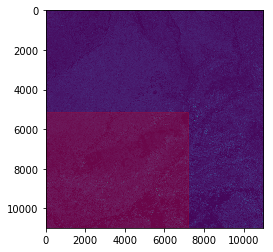

In [4]:
datos_b1 = src.read(1)
plt.imshow(datos_b1)
ax = plt.gca()
ax.add_patch(Rectangle((window_slice.col_off,window_slice.row_off), 
                       width=window_slice.width, 
                       height=window_slice.height,fill=True,alpha=.2,
                 color="red"))

## Read a `Window` from the raster object

We will plot the raster `Window` using `rasterio.plot`. Notice that in order to show the coordinates appropiately we must find the specific `Affine` transform of the `Window` (which consists just in shifting the origin of the original `src.transform`).

(5830, 7168, 3)


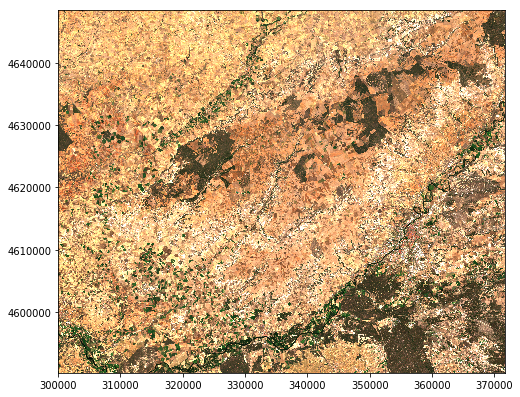

In [5]:
# find specific transform, necessary to show the coordinates appropiately
transform_window = windows.transform(window_slice,src.transform)

# Read img and convert to rgb
img = np.stack([src.read(4-i, window=window_slice) for i in range(1,4)],
               axis=-1)
img = np.clip(img,0,2200)/2200

print(img.shape)
plt.figure(figsize=(8,8))
plot.show(img.transpose(2,0,1),
          transform=transform_window)

In [6]:
# Useful functions

def reverse_coordinates(pol):
    """
    Reverse the coordinates in pol
    Receives list of coordinates: [[x1,y1],[x2,y2],...,[xN,yN]]
    Returns [[y1,x1],[y2,x2],...,[yN,xN]]
    """
    return [list(f[-1::-1]) for f in pol]

def to_index(wind_):
    """
    Generates a list of index (row,col): [[row1,col1],[row2,col2],[row3,col3],[row4,col4],[row1,col1]]
    """
    return [[wind_.row_off,wind_.col_off],
            [wind_.row_off,wind_.col_off+wind_.width],
            [wind_.row_off+wind_.height,wind_.col_off+wind_.width],
            [wind_.row_off+wind_.height,wind_.col_off],
            [wind_.row_off,wind_.col_off]]

def generate_polygon(bbox):
    """
    Generates a list of coordinates: [[x1,y1],[x2,y2],[x3,y3],[x4,y4],[x1,y1]]
    """
    return [[bbox[0],bbox[1]],
             [bbox[2],bbox[1]],
             [bbox[2],bbox[3]],
             [bbox[0],bbox[3]],
             [bbox[0],bbox[1]]]

def pol_to_np(pol):
    """
    Receives list of coordinates: [[x1,y1],[x2,y2],...,[xN,yN]]
    """
    return np.array([list(l) for l in pol])

def pol_to_bounding_box(pol):
    """
    Receives list of coordinates: [[x1,y1],[x2,y2],...,[xN,yN]]
    """
    arr = pol_to_np(pol)
    return BoundingBox(np.min(arr[:,0]),
                       np.min(arr[:,1]),
                       np.max(arr[:,0]),
                       np.max(arr[:,1]))

## Conversions

Next sections will cover the conversions of our window to different objects types.

### `Window` to `list` of index (row,col)

In [7]:
pol_index = to_index(window_slice)
pol_index

[[5150, 0], [5150, 7168], [10980, 7168], [10980, 0], [5150, 0]]

### Convert `list` of index (row,col) to `list` of coordinates

To obtain the coordinates of a list of *(row,col)* pairs we can directly multiply them by the `src.transform` object (from class `Affine`). However a couple of things must be taken into account: first the `src.transform` object transforms *(col,row)* coordinates (instead of *(row,col)*) so we must reverse our coordinates before multiplying. In addition, the multiplication returns the coordinates of the upper left (`ul`) pixel, therefore if we want the coordinates of the center pixel we should add `.5` to each of our *(row,col)* pairs. 

We can also use the build-in method `xy` from the raster object.

In [8]:
[list(src.transform*p) for p in reverse_coordinates(pol_index)]

[[300000.0, 4648540.0],
 [371680.0, 4648540.0],
 [371680.0, 4590240.0],
 [300000.0, 4590240.0],
 [300000.0, 4648540.0]]

In [9]:
[list(src.xy(*p,offset="center")) for p in pol_index]

[[300005.0, 4648535.0],
 [371685.0, 4648535.0],
 [371685.0, 4590235.0],
 [300005.0, 4590235.0],
 [300005.0, 4648535.0]]

In [10]:
[list(src.xy(*p,offset="ul")) for p in pol_index]

[[300000.0, 4648540.0],
 [371680.0, 4648540.0],
 [371680.0, 4590240.0],
 [300000.0, 4590240.0],
 [300000.0, 4648540.0]]

### Convert `Window` to `BoundingBox`

In [11]:
bbox = windows.bounds(window_slice,src.transform)
bbox

(300000.0, 4590240.0, 371680.0, 4648540.0)

### Convert `BoundingBox` to `Window`

In [12]:
window_same = windows.from_bounds(*bbox,src.transform)
window_same

Window(col_off=0.0, row_off=5150.0, width=7168.0, height=5830.0)

### `BoundingBox` to `list` of coordinates (closed)

In [13]:
pol = generate_polygon(bbox)
pol

[[300000.0, 4590240.0],
 [371680.0, 4590240.0],
 [371680.0, 4648540.0],
 [300000.0, 4648540.0],
 [300000.0, 4590240.0]]

### `list` of coordinates to `BoundingBox`

In [14]:
pol_to_bounding_box(pol)

BoundingBox(left=300000.0, bottom=4590240.0, right=371680.0, top=4648540.0)

## Change of Refence System (`CRS`) using `rasterio.warp`

We will change the reference system from the different types of objects we have generated so far. The source reference system of our raster is *UTM* `epsg:32630`. The target reference system we will use is `epsg:4326` which corresponds to standard *(longitude,latitude)* coordinates. Transformations are done using the `rasterio.warp` module. There are different functions depending on the objects we want to transform to.

### `transform` `list` of coordinates

In [15]:
pol_np = np.array(pol)
coords_transformed = warp.transform(src.crs,{'init': 'epsg:4326'},pol_np[:,0],pol_np[:,1])
coords_transformed = [[r,c] for r,c in zip(coords_transformed[0],coords_transformed[1])]
coords_transformed

[[-5.393939163550343, 41.4388362850582],
 [-4.536330188462325, 41.453491755554914],
 [-4.548885155675175, 41.97841583786727],
 [-5.413488998912444, 41.963489431071004],
 [-5.393939163550343, 41.4388362850582]]

### `transform` `BoundingBox`

In [16]:
bounds_trans = warp.transform_bounds(src.crs,{'init': 'epsg:4326'},*bbox)
print(bounds_trans)
pol_bounds_trans = generate_polygon(bounds_trans)
pol_bounds_trans

(-5.413488998912444, 41.4388362850582, -4.536330188462325, 41.97841583786727)


[[-5.413488998912444, 41.4388362850582],
 [-4.536330188462325, 41.4388362850582],
 [-4.536330188462325, 41.97841583786727],
 [-5.413488998912444, 41.97841583786727],
 [-5.413488998912444, 41.4388362850582]]

### `transform` `GeoJSON` like `dictionary`

A `GeoJSON` like `dictionary` in its simplest form is a `dictionary` with a a field `type` set to `Polygon` and a field `coordinates` as a `list` of `list` of coordinates. The function `warp.transform_geom` use format to transform geometries between different coordinate reference systems: `CRS`.

In [17]:
pol_trans = warp.transform_geom(src.crs,{'init': 'epsg:4326'},
                                {"type":"Polygon","coordinates":[pol]})
pol_trans

{'type': 'Polygon',
 'coordinates': [[(-5.393939163550343, 41.4388362850582),
   (-4.536330188462325, 41.453491755554914),
   (-4.548885155675175, 41.97841583786727),
   (-5.413488998912444, 41.963489431071004),
   (-5.393939163550343, 41.4388362850582)]]}

`pol_trans` and `coords_transformed` are the same but not the transformed coordinates of `BoundingBox` (`generate_polygon(bounds_trans)`). We could get the same `BoundingBox` if we use `pol_to_bounding_box`.

In [18]:
pol_to_bounding_box(pol_trans["coordinates"][0])

BoundingBox(left=-5.413488998912444, bottom=41.4388362850582, right=-4.536330188462325, top=41.97841583786727)

### Show polygons with `folium`

Watch out! `folium.Polygon` and `folium.Polyline` works with `(lat,lng)` coordinates instead of `(lng,lat)`.

In [85]:
bounds_trans_original = warp.transform_bounds(src.crs,{'init': 'epsg:4326'},
                                              *src.bounds)
polygon_trans_original = generate_polygon(bounds_trans_original)

polyline_polygon_trans_original = folium.PolyLine(reverse_coordinates(polygon_trans_original),
                                                  popup="polygon_trans_original",
                                                  color="#2ca02c")

polyline_pol_trans = folium.Polygon(reverse_coordinates(pol_trans["coordinates"][0]),
                                    popup="pol_trans",color="red",fill=True)

polyline_coords_transformed = folium.PolyLine(reverse_coordinates(coords_transformed),
                                              popup="coords_transformed")

polyline_pol_bounds_trans = folium.PolyLine(reverse_coordinates(pol_bounds_trans),
                                            popup="pol_bounds_trans",color="orange")

mean_lat = (bounds_trans[1] + bounds_trans[3]) / 2.0
mean_lng = (bounds_trans[0] + bounds_trans[2]) / 2.0
map_bb = folium.Map(location=[mean_lat,mean_lng],
                zoom_start=6)
map_bb.add_child(polyline_pol_trans)
map_bb.add_child(polyline_coords_transformed)
map_bb.add_child(polyline_pol_bounds_trans)
map_bb.add_child(polyline_polygon_trans_original)
map_bb

## Crop raster with a polygon (`list` of coordinates)

The simpler option is to use `rasterio.mask.mask` (see: [masking raster using a shapefile](https://rasterio.readthedocs.io/en/latest/topics/masking-by-shapefile.html)). First we define our polygon of the region of interest:

In [75]:
roi_polygon = [[-4.853330696593957,41.64565614198989],
               [-4.768186653625207,41.522392372903866],
               [-4.569059456359582,41.59432483529684],
               [-4.30,41.75229435821611],
               [-4.728361214172082,41.77073301997901],
               [-4.853330696593957,41.64565614198989]]
map_bb.add_child(folium.PolyLine(reverse_coordinates(roi_polygon),
                                 color="#222222"))
map_bb

Then we transform the roi which is given in long/lat coordinates to the raster coordinates (which are given in `src.crs`). With the polygon defined as a `GeoJSON` like `dictionary` we call `rasterio.mask.mask`. (Watch out this function is intended to work with a `list` of `GeoJSON` like `dictionary`(ies)).

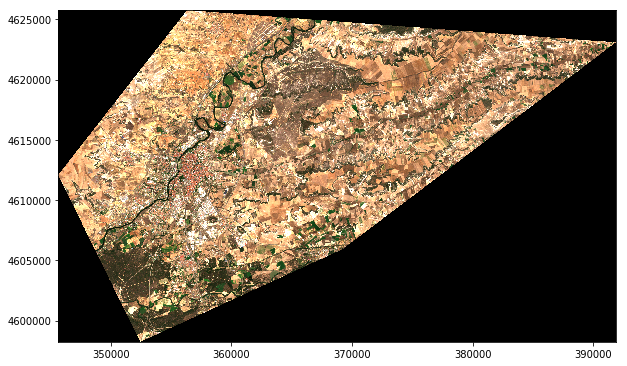

In [23]:
roi_polygon_src_coords = warp.transform_geom({'init': 'epsg:4326'},
                                             src.crs,                                            
                                             {"type": "Polygon", 
                                              "coordinates": [roi_polygon]})

out_image,out_transform = mask.mask(src,
                                    [roi_polygon_src_coords],
                                    crop=True)

out_image = np.clip(out_image[2::-1],
                    0,2200)/2200

plt.figure(figsize=(10,10))
plot.show(out_image,
          transform=out_transform)

### Intersect our window with the defined polygon

Great! so now suppose you are interested only in the intersection between the `roi_polygon` and our previously defined window. In this case we can use `shapely` to compute the intersection. With the intersected polygon we proceed as we did before.

In [24]:
from shapely.geometry import Polygon

pol_intersection = Polygon(pol_trans["coordinates"][0]).intersection(Polygon(roi_polygon))
pol_intersection = [list(l) for l in list(pol_intersection.exterior.coords)]
pol_intersection

[[-4.5437277787345245, 41.76278553698213],
 [-4.54010517941412, 41.61132439880385],
 [-4.569059456359582, 41.59432483529684],
 [-4.768186653625207, 41.522392372903866],
 [-4.853330696593957, 41.64565614198989],
 [-4.728361214172082, 41.77073301997901],
 [-4.5437277787345245, 41.76278553698213]]

In [76]:
map_bb.add_child(folium.PolyLine(reverse_coordinates(pol_intersection),
                                 color="#999999"))
map_bb

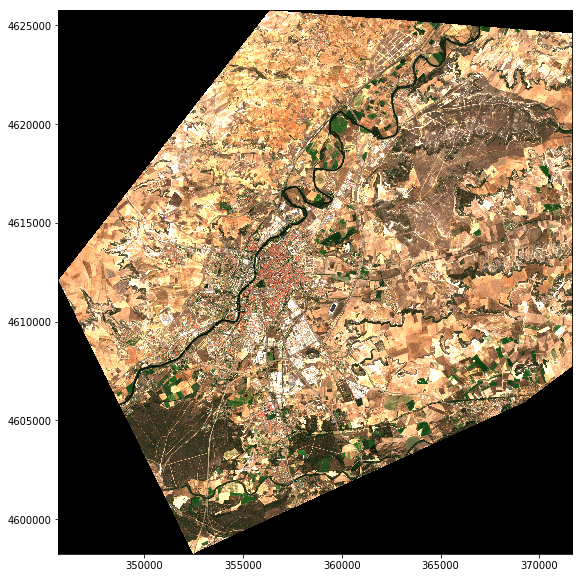

In [27]:
pol_intersection_src_coords = warp.transform_geom({'init': 'epsg:4326'},
                                                  src.crs,
                                                  {"type": "Polygon", 
                                                   "coordinates": [pol_intersection]})
out_image,out_transform = mask.mask(src,
                                    [pol_intersection_src_coords],
                                    crop=True)

out_image = np.clip(out_image[2::-1],
                    0,2200)/2200

plt.figure(figsize=(10,10))
plot.show(out_image,
          transform=out_transform)

## Reproject raster to different `CRS`

Using `warp.reproject`and `warp.calculate_default_transform` 

In [60]:
transform,width,height = warp.calculate_default_transform(src.crs, {"init":"epsg:4326"},
                                                          img.shape[1],img.shape[0],
                                                          left=bbox[0],bottom=bbox[1],
                                                          right=bbox[2],top=bbox[3],
                                                          resolution=0.002)

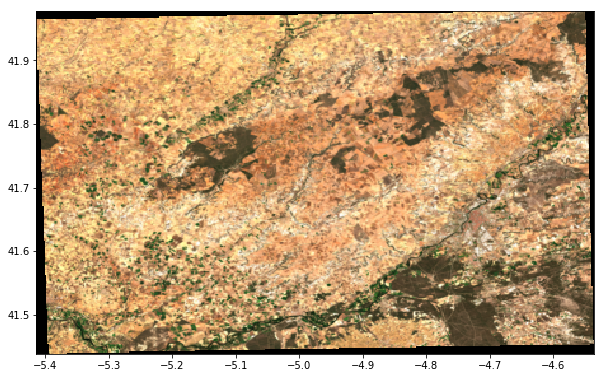

In [66]:
out_array = np.ndarray((img.shape[2],height,width),dtype=img.dtype)

warp.reproject(np.transpose(img,axes=(2,0,1)),
               out_array,src_crs=src.crs,dst_crs={"init":"epsg:4326"},
               src_transform=transform_window,
               dst_transform=transform,resampling=warp.Resampling.bilinear)

plt.figure(figsize=(10,8))
plot.show(out_array,
          transform=transform)

In [83]:
bounds_trans

(-5.413488998912444, 41.4388362850582, -4.536330188462325, 41.97841583786727)

In [84]:
polyline_polygon_trans_original = folium.PolyLine(reverse_coordinates(polygon_trans_original),
                                                  popup="polygon_trans_original",
                                                  color="#2ca02c")

polyline_pol_trans = folium.PolyLine(reverse_coordinates(pol_trans["coordinates"][0]),
                                    popup="pol_trans",color="blue")

polyline_pol_bounds_trans = folium.PolyLine(reverse_coordinates(pol_bounds_trans),
                                            popup="pol_bounds_trans",color="orange")

mean_lat = (bounds_trans[1] + bounds_trans[3]) / 2.0
mean_lng = (bounds_trans[0] + bounds_trans[2]) / 2.0
map_bb = folium.Map(location=[mean_lat,mean_lng],
                zoom_start=8)
map_bb.add_child(polyline_pol_trans)
map_bb.add_child(polyline_pol_bounds_trans)
map_bb.add_child(polyline_polygon_trans_original)
image_overlay = folium.raster_layers.ImageOverlay(np.transpose(out_array,(1,2,0)),
                                                  [[bounds_trans[1],
                                                    bounds_trans[0]],
                                                   [bounds_trans[3],
                                                    bounds_trans[2]]])
map_bb.add_child(image_overlay)
map_bb